In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint

import random
import tensorflow as tf
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Read the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#read the data Colab
filepath = os.path.join('drive','MyDrive','Final Project','GDP.csv')
df_org = pd.read_csv(filepath)
df_org.info()
df_org.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Columns: 227 entries, Country Name to Unnamed: 226
dtypes: float64(222), int64(1), object(4)
memory usage: 1011.0+ KB


,Country Name,Country Code,Indicator Name,Indicator Code,Attribute,1800,1801,1802,1803,1804,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 226
0,Papua New Guinea,853,Gross Government Debt,GGXWDG,Value,NaN,NaN,NaN,NaN,NaN,...,8.565531e+09,1.176576e+10,1.482730e+10,1.580891e+10,1.616781e+10,1.670647e+10,1.667034e+10,1.633275e+10,1.552917e+10,NaN
1,Paraguay,288,Gross Government Debt,GGXWDG,Value,NaN,NaN,NaN,NaN,NaN,...,1.760297e+13,2.096252e+13,2.633586e+13,3.298367e+13,3.828361e+13,4.343323e+13,4.902607e+13,5.462696e+13,6.051216e+13,NaN
2,Peru,293,Gross Government Debt,GGXWDG,Value,NaN,NaN,NaN,NaN,NaN,...,1.077037e+11,1.110170e+11,1.193030e+11,1.350758e+11,1.550643e+11,1.683184e+11,1.783528e+11,1.863985e+11,1.995994e+11,NaN
3,Philippines,566,Gross Government Debt,GGXWDG,Value,NaN,NaN,NaN,NaN,NaN,...,4.288804e+12,4.529800e+12,4.602500e+12,4.853522e+12,5.038158e+12,5.246268e+12,5.472505e+12,5.722527e+12,5.997655e+12,NaN
4,Poland,964,Gross Government Debt,GGXWDG,Value,NaN,NaN,NaN,NaN,NaN,...,8.784150e+11,9.261160e+11,8.665020e+11,9.144117e+11,9.600945e+11,1.011376e+12,1.059549e+12,1.101687e+12,1.146170e+12,NaN


In [6]:
df_org.shape # (570, 227)

(570, 227)

# Preproceing

In [7]:
#Drop unnecessary columns 
df_org.drop(columns =['Unnamed: 226', 'Country Code','Indicator Code','Attribute'],inplace = True)


In [8]:
# Convert year into column and convert into type int
df = df_org.melt(id_vars =['Country Name','Indicator Name'], var_name = 'Year', value_name='Value')
df['Year'] = df['Year'].astype(int)
df

,Country Name,Indicator Name,Year,Value
0,Papua New Guinea,Gross Government Debt,1800,NaN
1,Paraguay,Gross Government Debt,1800,NaN
2,Peru,Gross Government Debt,1800,NaN
3,Philippines,Gross Government Debt,1800,NaN
4,Poland,Gross Government Debt,1800,NaN
...,...,...,...,...
125965,Afghanistan,Gross Domestic Product,2020,1.815953e+12
125966,"Micronesia, Fed. States of",Gross Domestic Product,2020,3.452795e+08
125967,"Micronesia, Fed. States of",Gross Government Debt,2020,1.063630e+08
125968,"Micronesia, Fed. States of",Debt to GDP Ratio,2020,3.080491e+01


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125970 entries, 0 to 125969
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    125970 non-null  object 
 1   Indicator Name  125970 non-null  object 
 2   Year            125970 non-null  int64  
 3   Value           32537 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.8+ MB


In [10]:
# Create dataset from neighbours countries + Germany
countries_list =['Croatia','FYR Macedonia ','Bosnia and Herzegovina','Slovenia','Albania','Greece','Bulgaria','Romania','Germany']
df_countries = df[df['Country Name'].isin(countries_list)].sort_values(by = 'Year') 

In [11]:
# Replace names 
df_countries['Indicator Name'] = df_countries['Indicator Name'].replace({'Gross Government Debt':'GGD' , 'Gross Domestic Product':'GDP','Debt to GDP Ratio' : 'Ratio'})
df_countries['Country Name'] = df_countries['Country Name'].replace({'FYR Macedonia ' : 'Macedonia'})
df_countries

,Country Name,Indicator Name,Year,Value
7,Romania,GGD,1800,NaN
518,Albania,GGD,1800,NaN
509,Bulgaria,GGD,1800,NaN
505,Bosnia and Herzegovina,GGD,1800,NaN
500,Germany,GDP,1800,NaN
...,...,...,...,...
125444,Romania,Ratio,2020,4.407791e+01
125407,Romania,GGD,2020,4.064346e+11
125909,Bulgaria,GGD,2020,2.730852e+10
125744,Slovenia,GDP,2020,4.534210e+10


In [12]:
#Check for nan values
df_countries[(df_countries['Year'] > 1996) & (df_countries['Value']).isna()]

,Country Name,Indicator Name,Year,Value
112762,Macedonia,GGD,1997,NaN
112795,Bosnia and Herzegovina,GGD,1997,NaN
112799,Bulgaria,GGD,1997,NaN
112651,Bosnia and Herzegovina,Ratio,1997,NaN
112643,Croatia,GGD,1997,NaN
113332,Macedonia,GGD,1998,NaN


In [13]:
#Filling nan values for GGD and Ratio with proportional calculation (Macedonia, Bulgaria, Croatia)

# Create a temporary df
temp_df = df_countries.pivot_table(index=['Country Name', 'Year'], columns='Indicator Name', values='Value').reset_index()

#Calculate Ratio and GGD
temp_df['GGD_filled'] = (temp_df['Ratio'] * temp_df['GDP']) // 100
temp_df['Ratio_filled'] = (temp_df['GGD'] // temp_df['GDP']) * 100

# Merge the values into df
df_countries = df_countries.merge(temp_df[['Country Name', 'Year', 'GGD_filled','Ratio_filled']], on=['Country Name', 'Year'], how='left')

# Fill NaN values 
df_countries.loc[(df_countries['Indicator Name'] == 'GGD') & (df_countries['Value'].isna()), 'Value'] = df_countries['GGD_filled']
df_countries.loc[(df_countries['Indicator Name'] == 'Ratio') & (df_countries['Value'].isna()), 'Value'] = df_countries['Ratio_filled']

# Drop temp columns
df_countries = df_countries.drop(columns=['GGD_filled','Ratio_filled'])



In [14]:
#Check for nan values again
df_countries[(df_countries['Year'] > 1996) & (df_countries['Value']).isna()]

,Country Name,Indicator Name,Year,Value
5326,Bosnia and Herzegovina,GGD,1997,NaN
5330,Bosnia and Herzegovina,Ratio,1997,NaN


In [15]:
# Filling nan values with fill forward method (for Bosnia)
mean_ratio = df_countries[df_countries['Indicator Name'] == 'Ratio']['Value'].mean()
mean_ggd = df_countries[df_countries['Indicator Name'] == 'GGD']['Value'].mean()

# Define a function to fill NaN values based on the Indicator Name
def fill_nan_values(row):
    if pd.isna(row['Value']):
        if row['Indicator Name'] == 'Ratio':
            return mean_ratio
        elif row['Indicator Name'] == 'GGD':
            return mean_ggd
    return row['Value']

# Apply the function and update the 'Value' column
df_countries['Value'] = df_countries.apply(fill_nan_values, axis=1)


In [16]:
#Check for nan values again
df_countries[(df_countries['Year'] > 1996) & (df_countries['Value']).isna()]

,Country Name,Indicator Name,Year,Value


In [17]:
# Creating separate datasets for each indicator individually
df_countries_ratio = df_countries[(df_countries['Indicator Name'] == 'Ratio') & (df_countries['Year'] > 1996)]
df_countries_gdp = df_countries[(df_countries['Indicator Name'] == 'GDP') & (df_countries['Year'] > 1996)]
df_countries_ggd = df_countries[(df_countries['Indicator Name'] == 'GGD') & (df_countries['Year'] > 1996)]


In [18]:
# # Dividing GDP Value with 1000000
# df_countries_gdp['Value'] = df_countries_gdp['Value'] // 1000000
# df_countries_ggd['Value'] = df_countries_ggd['Value'] // 1000000

# # Round value in df_balkan_ratio on 2 decimals
# df_countries_ratio['Value']=df_countries_ratio['Value'].round(2)

# Univariate and bivariate analyze 

In [19]:
# so vizualizacija da dobieme edna opsta slika za site indikatori, a potoa fokus na GDP
fig = px.bar(df_countries_ratio, x='Country Name', y='Value', title = 'Debt to GDP Ratio')
fig.show()

In [20]:
# # Pivot tables , Year as index
df_countries_gdp =df_countries_gdp.pivot(index='Year', columns='Country Name', values='Value')
df_countries_ggd= df_countries_ggd.pivot(index='Year', columns='Country Name', values='Value')
df_countries_ratio = df_countries_ratio.pivot(index='Year', columns='Country Name', values='Value')

In [21]:
px.line(df_countries_ratio, title ='Line trend of Debt to GDP Ratio')

In [22]:
fig = px.box(df_countries_ratio, title = ' Box Plot of Dept to GDP Ratio')
fig.show()

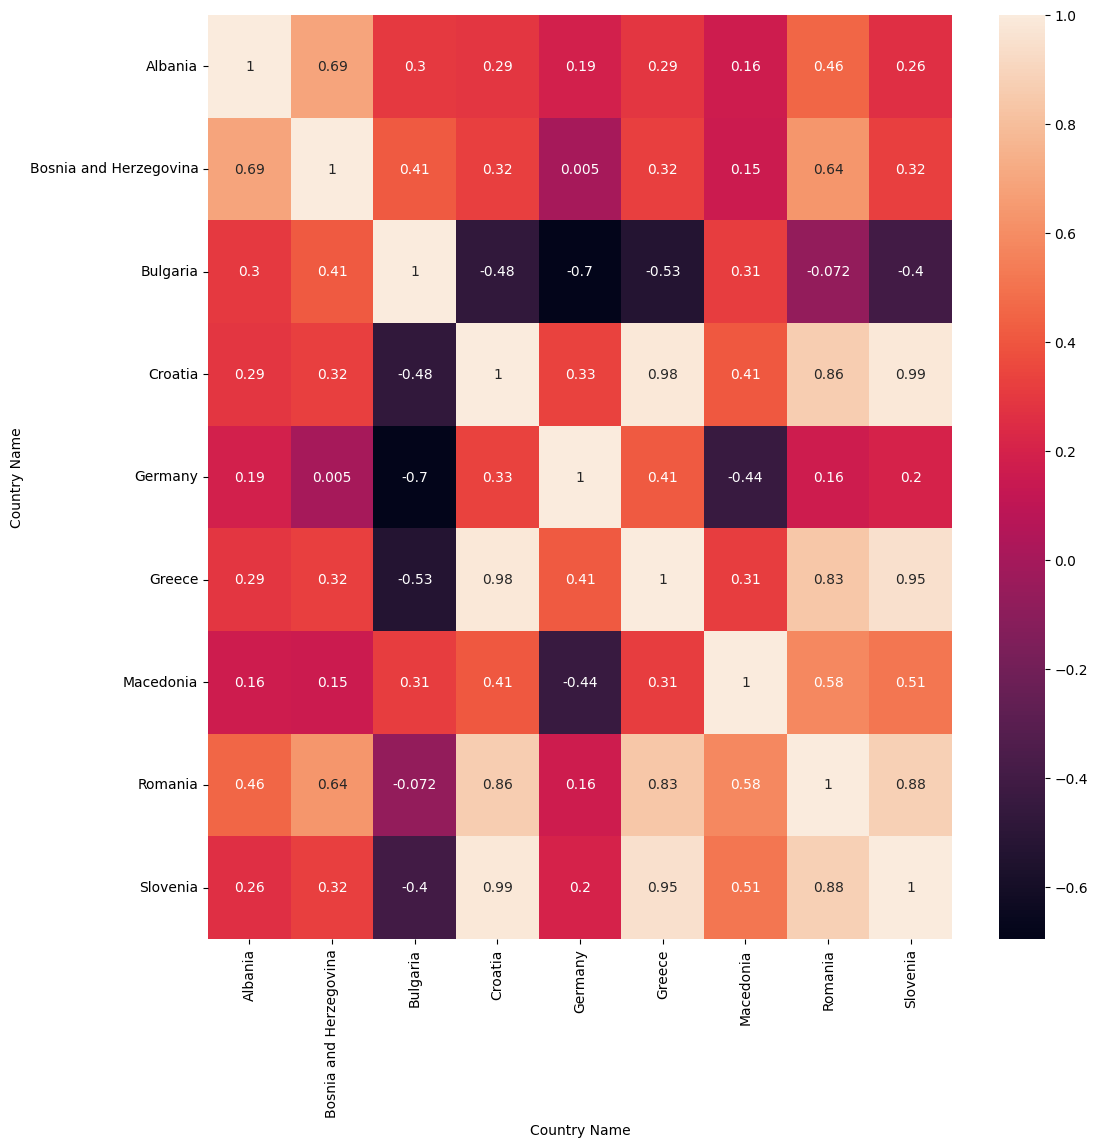

In [23]:
# Correlation Ratio
plt.figure(figsize = (12,12))
correlation = df_countries_ratio.corr ()
heatmap = sns.heatmap(correlation, annot = True,cmap ='rocket')

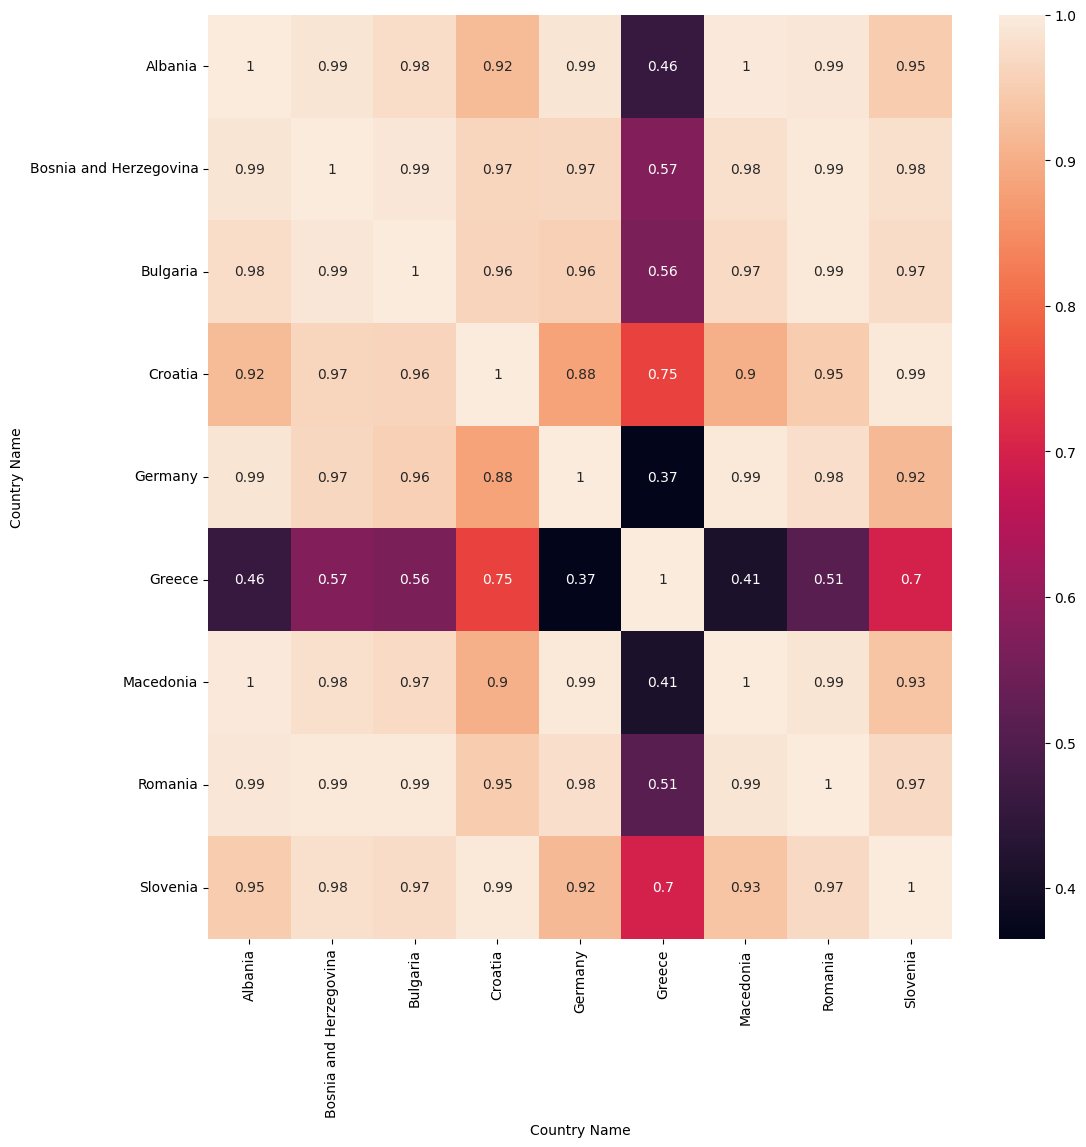

In [24]:
# Correlation GDP
plt.figure(figsize = (12,12))
correlation = df_countries_gdp.corr()
heatmap = sns.heatmap(correlation, annot = True,cmap ='rocket')

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_countries_gdp)

sns.pairplot(pd.DataFrame(scaled))

# Creating models ( LR, Arima , LSTM) for prediction of GDP - target Macedonia

### 1) Linear Regresion

In [26]:
# Define target
target = 'Macedonia'
dfmx = df_countries_gdp[target] # filter by country
dfmx = pd.DataFrame(dfmx)
dfmx

,Macedonia
Year,
1997,1.956065e+11
1998,2.050288e+11
1999,2.199184e+11
2000,2.486460e+11
2001,2.523930e+11
2002,2.585810e+11
2003,2.686930e+11
2004,2.807870e+11
2005,3.084470e+11


710417767876.1094
Model Prediction GDP MK (2021) = 710417.0 milioni MKD
SciPy


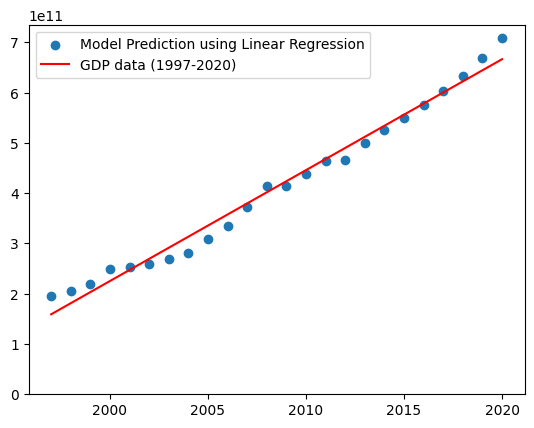

In [27]:
#Linear regresion
X = dfmx.index
y = dfmx.Macedonia
slope, intercept, r, p, std_err = stats.linregress(X, y) # scipy

def modelPrediction(x):
  return slope * x + intercept

model = list(map(modelPrediction, X)) # scipy
x_pred = 2022
y_pred = modelPrediction(x_pred)
print(y_pred)
print('Model Prediction GDP MK (2021) = {} milioni MKD'.format(y_pred//1000000))
print('SciPy')
plt.scatter(X, y) # Scatter Plot
plt.plot(X, model, color='red') # linestyle='dashed', marker='o', markersize=12, markerfacecolor='blue'
plt.ylim(ymin=0) # starts at zero
plt.legend(['Model Prediction using Linear Regression', 'GDP data (1997-2020)'])
plt.show()




### 2) ARIMA

In [28]:
df_countries_gdp.head()

Country Name,Albania,Bosnia and Herzegovina,Bulgaria,Croatia,Germany,Greece,Macedonia,Romania,Slovenia
Year,,,,,,,,,
1997,3.461978e+11,7.894222e+09,1.882993e+10,1.252864e+11,1.967090e+12,1.148349e+11,1.956065e+11,2.571264e+10,1.382720e+10
1998,4.092088e+11,9.218545e+09,2.575637e+10,1.392439e+11,2.018230e+12,1.256875e+11,2.050288e+11,3.800065e+10,1.533740e+10
1999,4.715785e+11,1.057107e+10,2.510229e+10,1.432673e+11,2.064880e+12,1.342177e+11,2.199184e+11,5.547940e+10,1.721040e+10
2000,5.230434e+11,1.178998e+10,2.835413e+10,1.802410e+11,2.116480e+12,1.417319e+11,2.486460e+11,8.127530e+10,1.890200e+10
2001,5.833686e+11,1.264120e+10,3.124975e+10,1.942700e+11,2.179850e+12,1.519872e+11,2.523930e+11,1.183272e+11,2.114680e+10


In [29]:
df_arima = df_countries_gdp.copy()

In [30]:
# Convert Index - Year to datetime

df_arima.index = pd.to_datetime(df_arima.index, format='%Y')

<Axes: xlabel='Year', ylabel='Macedonia'>

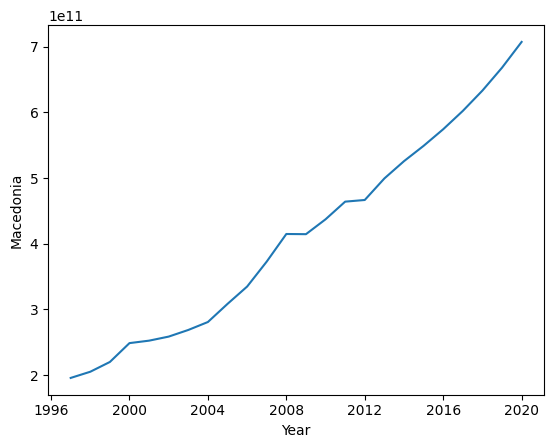

In [31]:
sns.lineplot(df_arima, x = 'Year', y='Macedonia')

In [32]:
NORMALIZE=False
LOG = True
colname='Macedonia'
if NORMALIZE: 
    df_arima[colname] = MinMaxScaler().fit_transform(df_arima[colname].values.reshape(-1,1))
if LOG:
    df_arima[colname] = np.log(df_arima[colname]+1)
    
train_cutoff = int(0.80*df_arima.shape[0])
train_df = df_arima.iloc[:train_cutoff][[colname]].copy()
test_df = df_arima.iloc[train_cutoff:][[colname]].copy()

<Axes: xlabel='Year', ylabel='Macedonia'>

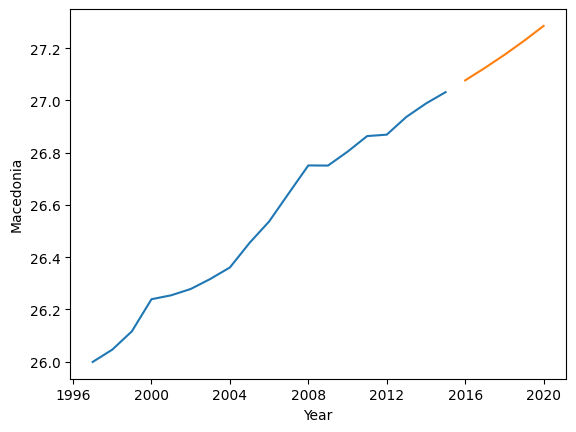

In [33]:
sns.lineplot(train_df, x = 'Year', y=colname)
sns.lineplot(test_df, x = 'Year', y=colname)

<Figure size 1200x600 with 0 Axes>

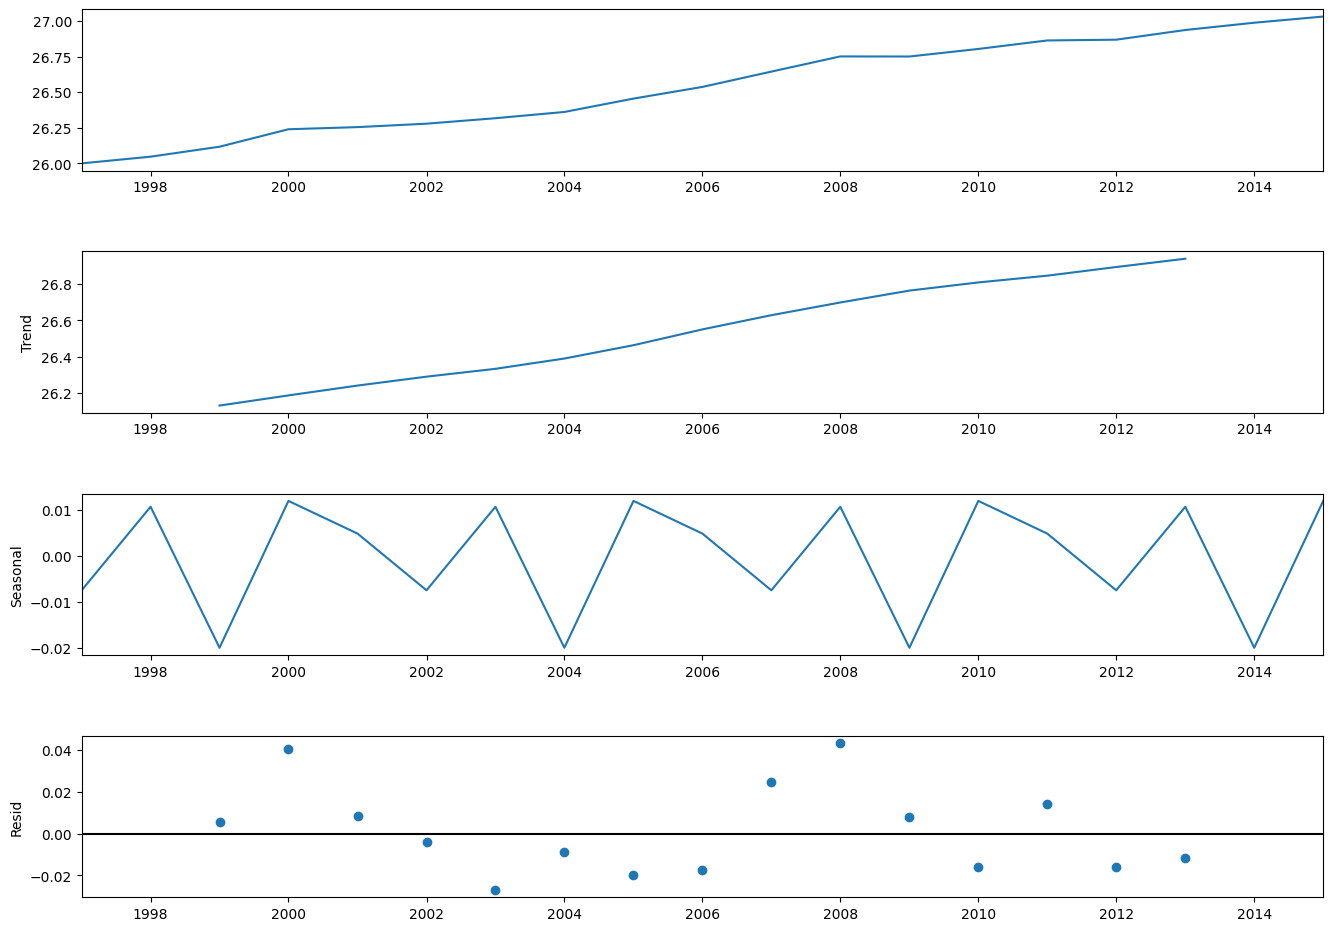

In [34]:
fig = plt.figure(figsize=(12, 6))
rez = seasonal_decompose(train_df, model='additive',period = 5)    
fig = rez.plot() 
fig.set_figwidth(15)
fig.set_figheight(10)

- p: number of autoregressive terms (AR order)
- d: number of nonseasonal differences (differencing order)
- q: number of moving-average terms (MA order)

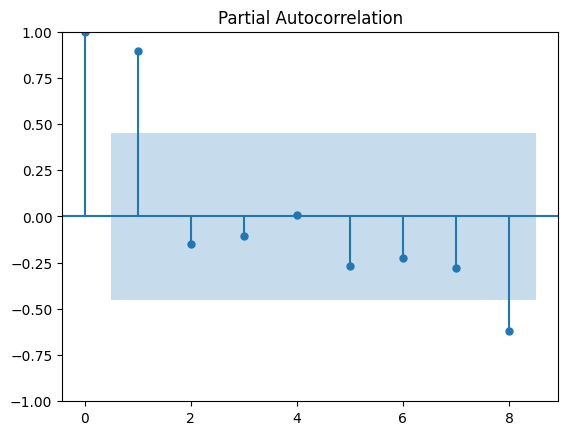

In [35]:
# Determine the optimal value of "p" using the PACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(train_df, lags = 8)
plt.show()

#p =1

In [36]:
# Determine optimal value of d using adfuller test 

from statsmodels.tsa.stattools import adfuller
rez = adfuller(train_df) # d = 0
print('p-value: %f' % rez[1])

rez = adfuller(train_df.diff().dropna()) # d = 1 
print('p-value: %f' % rez[1])


rez = adfuller(train_df.diff().diff().dropna()) # d = 2
print('p-value: %f' % rez[1])

#d= 1

p-value: 0.524468
p-value: 0.015621
p-value: 0.018232


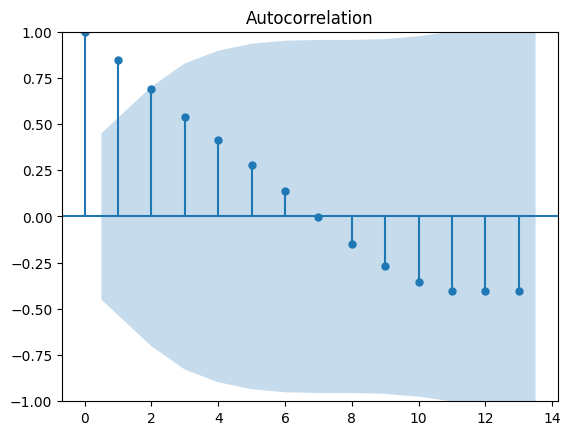

In [37]:
# # Determine optimal value of q using acf

plot_acf(train_df)
plt.show()

#q =1


In [38]:
from statsmodels.tsa.arima.model import ARIMA
p = 1
d = 1
q = 1
model = ARIMA(train_df, order=(p,d,q)) # p,d,q
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              Macedonia   No. Observations:                   19
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  32.644
Date:                Thu, 18 May 2023   AIC                            -59.289
Time:                        06:24:11   BIC                            -56.618
Sample:                    01-01-1997   HQIC                           -58.920
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.015     67.056      0.000       0.970       1.029
ma.L1         -0.9615      0.896     -1.073      0.283      -2.718       0.795
sigma2         0.0013      0.001      0.958      0.3

<Axes: xlabel='Year', ylabel='predicted_mean'>

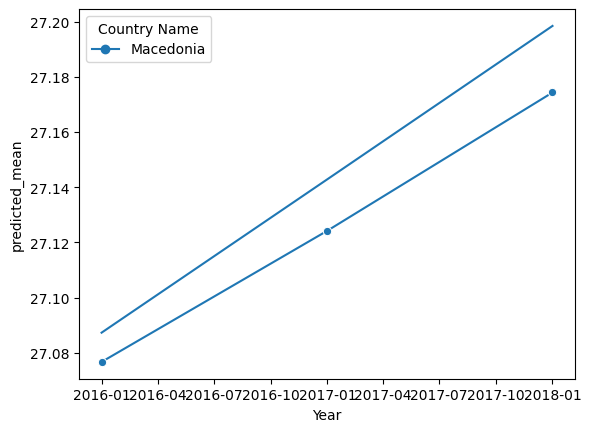

In [39]:
points_to_predict = 3
sns.lineplot(results.forecast(points_to_predict))
sns.lineplot(test_df.iloc[:points_to_predict], markers=True)

In [40]:
y_pred = results.forecast(points_to_predict)
y_pred

2016-01-01    27.087306
2017-01-01    27.142900
2018-01-01    27.198476
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_pred, test_df[:points_to_predict])
r2 =r2_score(y_pred, test_df[:points_to_predict])
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R2 Score (R2): {r2:.2f}")

Mean Absolute Error (MAE): 0.02
R2 Score (R2): 0.83


### 3) Sequential model with LSTM

> 1) Many to one - Univariate

In [42]:
def split_data(df:pd.DataFrame , target :str):
    df_target = df[[target]].values
    idx = int(0.8*df_target.shape[0])
    train = df_target[:idx]
    test = df_target[idx:]
    return train,test

In [43]:
def create_sequences(data, look_back): 
    dataX, dataY = [], []
    for i in range(len(data) - look_back):
        dataX.append(data[i:(i+look_back), :])
        dataY.append(data[i+look_back, :])
    return np.array(dataX), np.array(dataY)

In [44]:
def make_model(LOOKBACK:int, show_summary:bool=False) -> Sequential :
    model = Sequential()

    model.add(LSTM(100, activation='relu', input_shape=(LOOKBACK, 1),return_sequences=True))
    model.add(LSTM(60, activation='relu', input_shape=(LOOKBACK, 1)))

    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mae')

    if show_summary:
        model.summary()

    return model

In [45]:
def train_model(model, trainX, trainY, testX, testY):

    es_cbk = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_history = model.fit(
    trainX,
    trainY,
    epochs=20,
    batch_size=1,
    validation_data = (testX, testY),
    callbacks = [es_cbk],
    verbose = 0
)
    return model_history

In [46]:
def create_plot (df, target,LOOKBACK, train_pred, test_pred):
    data_plot = pd.DataFrame(df[target])
    plt.plot(data_plot.values)
      
    train_plot = np.empty_like(data_plot)
    train_plot[:] = np.nan
    train_plot[LOOKBACK:LOOKBACK+len(train_pred), :] = train_pred
    plt.plot(train_plot)
    
    test_plot = np.empty_like(data_plot)
    test_plot[:] = np.nan
    test_plot[len(train_pred) + (2*LOOKBACK):len(data_plot), :] = test_pred 
    plt.plot(test_plot)

In [47]:
def eval_model(df,target,LOOKBACK,model,trainX, testX, testY):
    
    test_pred = model.predict(testX)
    train_pred = model.predict(trainX)

    create_plot (df, target,LOOKBACK, train_pred, test_pred)

    print('mae = ',mean_absolute_error(testY[:, 0], test_pred[:, 0]))
    print('r2_score = ', r2_score(testY[:, 0], test_pred[:,0]))   
    

In [48]:
def model_loop(LOOKBACK:int, df: pd.DataFrame,target: str):
    
    train,test = split_data(df,target)
    trainX,trainY = create_sequences(train, LOOKBACK)
    testX,testY = create_sequences(test, LOOKBACK)
    model = make_model(LOOKBACK)
    
    print("Training model...", end='')
    model_hist = train_model(model, trainX, trainY, testX, testY)
    print("Done.")
    
    eval_model(df,target,LOOKBACK,model,trainX,testX,testY)

Training model...Done.
1/1 [==============================] - 0s 21ms/step
mae =  7634785569.104329
r2_score =  0.9281593455716998


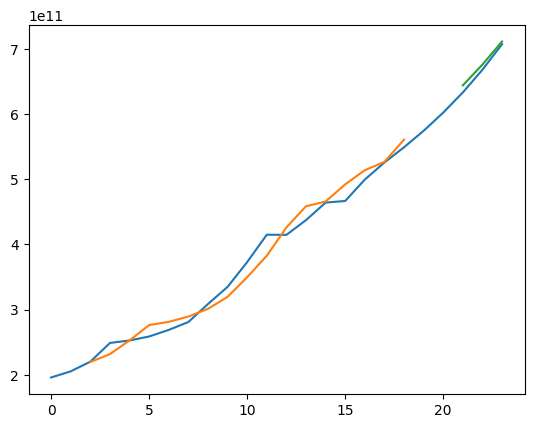

In [49]:
model_loop(2,df_countries_gdp,'Macedonia')

Training model...Done.
1/1 [==============================] - 0s 32ms/step
mae =  15240223445.746744
r2_score =  0.9497903639411953


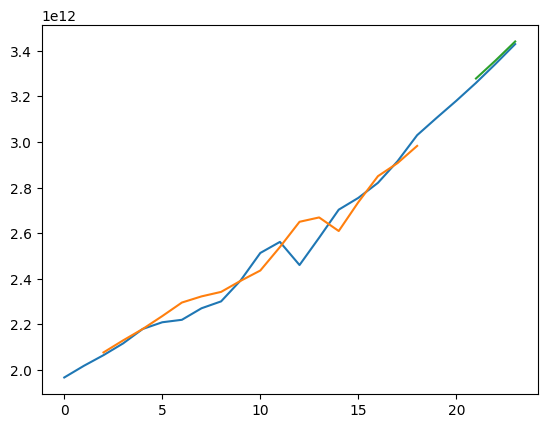

In [50]:
model_loop(2,df_countries_gdp,'Germany')

> 2) Many to Many - Multivariate

In [67]:
from re import VERBOSE
def split_scal_data(df:pd.DataFrame):
    data = df.values
    cut_off = int(0.7*data.shape[0])
    train = data[:cut_off]
    test = data[cut_off:]
    train = np.log(train)
    test = np.log(test)
    return train, test

def create_sequences_mm(data, n_steps_in, n_steps_out,feat_idxs,target_idx): # many to many:
    dataX, dataY = [], []
    for i in range(len(data)):
        in_end_idx = i+n_steps_in
        out_end_ix = in_end_idx+n_steps_out
        if out_end_ix > len(data):
             break
        dataX.append(data[i:in_end_idx,feat_idxs])
        dataY.append(data[in_end_idx:out_end_ix,target_idx])
    return np.array(dataX), np.array(dataY)

def make_model_mm(n_steps_in, n_steps_out, len_feat_idxs ):
    model = Sequential()

    model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, len_feat_idxs)))  
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(60, activation='relu', return_sequences=True))

    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mae')

    return model  

def train_model_mm(model,trainX,trainY,testX,testY):
        es_cbk = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model_history = model.fit(
                                trainX,
                                trainY,
                                epochs=20,
                                batch_size=1,
                                validation_data = (testX, testY),
                                callbacks=[es_cbk],
                                verbose = 0
                        )
        return model_history 

def eval_model_mm(model,trainX,testX,testY): 
        train_predict = model.predict(trainX,verbose=0)       
        test_predict  = model.predict(testX,verbose=0)

        mae = mean_absolute_error(testY[:, 0], test_predict[:, 0])
        r2 = r2_score(testY[:, 0], test_predict[:, 0])

        return[mae,r2,train_predict,test_predict]

def plot(df, target, n_steps_in,n_steps_out,train_predict,test_predict):
    
    train_predict = train_predict[::n_steps_out]
    train_predict = np.exp(train_predict)
    train_predict = train_predict.flatten()
    test_predict = np.exp(test_predict)
    test_predict = test_predict.flatten()
    trg = df[target]
  
    plt.plot(trg.values)
    train_plot = np.empty_like(trg)
    train_plot[:] = np.nan

    train_plot[n_steps_in:n_steps_in+len(train_predict)] = train_predict
    plt.plot(train_plot)

    test_plot = np.empty_like(trg)
    test_plot[:] = np.nan
    test_plot[len(train_predict) + (2*n_steps_in):len(trg)] = test_predict
    plt.plot(test_plot)

     

In [68]:
def model_loop_mm(df:pd.DataFrame, n_steps_in:int, n_steps_out:int,feat_idxs:tuple,target_idx:int):
    len_feat_idxs=len(feat_idxs)
    
    train,test = split_scal_data(df)
    trainX, trainY = create_sequences_mm(train, n_steps_in, n_steps_out,feat_idxs,target_idx)
    testX, testY = create_sequences_mm(test,n_steps_in, n_steps_out,feat_idxs,target_idx)
    testX = testX[::n_steps_out]
    testY = testY[::n_steps_out]
    
    model = make_model_mm(n_steps_in, n_steps_out, len_feat_idxs )
    
    model_hist = train_model_mm(model, trainX, trainY, testX, testY)
    
    
    [mae,r2,train_predict,test_predict] = eval_model_mm(model,trainX,testX,testY) 

    return [mae,r2,train_predict,test_predict]   

In [69]:
def model_results(df: pd.DataFrame, hyper_dict):    
    best_r2 = 0
    eval_dict = dict()
    best_hd=dict()

    for hd in hyper_dict: 
        n_steps_in = hd['n_steps_in']
        n_steps_out = hd['n_steps_out']      
        feat_idxs = hd['feat_idxs']
        target_idx = hd['target_idx']
        eval_dict[str(hd)] = model_loop_mm(df=df, n_steps_in = hd['n_steps_in'] , n_steps_out = hd['n_steps_out'] ,feat_idxs = hd['feat_idxs'],target_idx = hd['target_idx'] )
        if eval_dict[str(hd)][1] > best_r2:
            best_r2 = eval_dict[str(hd)][1]
            best_hd = hd
            best_train = eval_dict[str(hd)][2]
            best_test = eval_dict[str(hd)][3]
                
    df_results=pd.DataFrame.from_dict(eval_dict, orient='index', columns=['mae','r2','train_predict','test_predict']).sort_values(by='r2', ascending=False)
    display(df_results[['mae','r2']])
    print('Best_model:')
    t=best_hd['target_idx']
    print('target = ',df.columns[t])
    print('features = ',[df.columns[i] for i in  best_hd['feat_idxs']])
    plot(df, df.columns[t], best_hd['n_steps_in'],best_hd['n_steps_out'] ,best_train,best_test)
    

In [70]:
df_countries_gdp.head()

Country Name,Albania,Bosnia and Herzegovina,Bulgaria,Croatia,Germany,Greece,Macedonia,Romania,Slovenia
Year,,,,,,,,,
1997,3.461978e+11,7.894222e+09,1.882993e+10,1.252864e+11,1.967090e+12,1.148349e+11,1.956065e+11,2.571264e+10,1.382720e+10
1998,4.092088e+11,9.218545e+09,2.575637e+10,1.392439e+11,2.018230e+12,1.256875e+11,2.050288e+11,3.800065e+10,1.533740e+10
1999,4.715785e+11,1.057107e+10,2.510229e+10,1.432673e+11,2.064880e+12,1.342177e+11,2.199184e+11,5.547940e+10,1.721040e+10
2000,5.230434e+11,1.178998e+10,2.835413e+10,1.802410e+11,2.116480e+12,1.417319e+11,2.486460e+11,8.127530e+10,1.890200e+10
2001,5.833686e+11,1.264120e+10,3.124975e+10,1.942700e+11,2.179850e+12,1.519872e+11,2.523930e+11,1.183272e+11,2.114680e+10


In [71]:
hyper_dict1 = {               
                'n_steps_in' : 2,                  
                'n_steps_out' : 2,
                'feat_idxs' :(0,2,6),
                'target_idx' : 6   
            }

hyper_dict2 = {                 
                'n_steps_in' : 2,                  
                'n_steps_out' : 2,
                'feat_idxs' :(0,2,4,6),
                'target_idx' : 6 
            }
hyper_dict3 = {                 
                'n_steps_in' : 2,                  
                'n_steps_out' : 2,
                'feat_idxs' :(0,1,2,6),
                'target_idx' : 6 
            }

hyper_dict = [hyper_dict1,hyper_dict2,hyper_dict3]

,mae,r2
"{'n_steps_in': 2, 'n_steps_out': 2, 'feat_idxs': (0, 1, 2, 6), 'target_idx': 6}",0.016216,0.942143
"{'n_steps_in': 2, 'n_steps_out': 2, 'feat_idxs': (0, 2, 4, 6), 'target_idx': 6}",0.096706,-0.476096
"{'n_steps_in': 2, 'n_steps_out': 2, 'feat_idxs': (0, 2, 6), 'target_idx': 6}",0.108304,-0.832031


Best_model:
target =  Macedonia
features =  ['Albania', 'Bosnia and Herzegovina', 'Bulgaria', 'Macedonia']


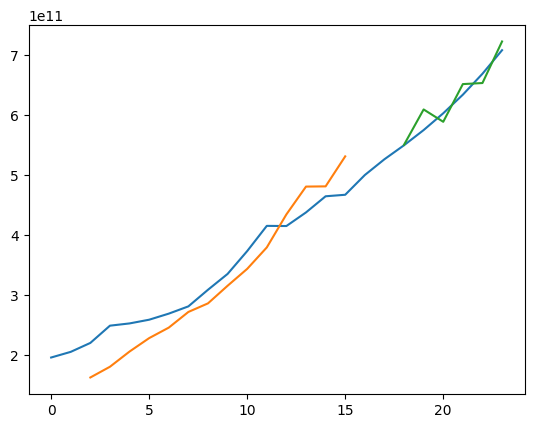

In [72]:
model_results(df_countries_gdp, hyper_dict)